In [32]:
import pandas as pd
import torch
import numpy as np
from pathlib import Path
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import torch.nn as nn
import matplotlib.pyplot as plt
from xgboost import XGBClassifier

from trump_dataset import TrumpDataset
from trump_model import TrumpNet


In [33]:
import importlib
import trump_model
importlib.reload(trump_model)

from trump_model import TrumpNet

In [34]:
path_to_data = Path('C:\\Users\\niede\\PycharmProjects\\jass-kit-py\\')
# Load CSV
data = pd.read_csv(path_to_data / '2018_10_18_trump.csv')

# Column names
cards = [
    'DA','DK','DQ','DJ','D10','D9','D8','D7','D6',
    'HA','HK','HQ','HJ','H10','H9','H8','H7','H6',
    'SA','SK','SQ','SJ','S10','S9','S8','S7','S6',
    'CA','CK','CQ','CJ','C10','C9','C8','C7','C6'
]

forehand = ['FH']
user = ['user']
trump = ['trump']

# Assign column names
data.columns = cards + forehand + user + trump

# Drop the user column
data = data.drop(columns=['user'])

# Convert trump column to category
data.trump = data.trump.astype('category')

# Convert card columns and forehand column to boolean
data[cards + forehand] = data[cards + forehand].astype(bool)

# Rename trump categories (merge 6 and 10 as PUSH)
data.trump = data.trump.cat.rename_categories({
    0: 'DIAMONDS',
    1: 'HEARTS',
    2: 'SPADES',
    3: 'CLUBS',
    4: 'OBE_ABE',
    5: 'UNE_UFE',
    6: 'PUSH',
    10: 'PUSH'
})

data.head()


,DA,DK,DQ,DJ,D10,D9,D8,D7,D6,HA,...,CK,CQ,CJ,C10,C9,C8,C7,C6,FH,trump
0,False,False,False,False,False,False,False,False,True,True,...,False,False,True,False,False,False,True,False,False,UNE_UFE
1,True,False,False,True,False,False,False,False,False,False,...,False,True,False,False,False,False,True,True,False,PUSH
2,False,False,False,False,False,False,False,False,False,True,...,False,False,False,True,True,False,False,False,False,UNE_UFE
3,False,True,False,False,False,False,False,False,True,True,...,False,False,True,False,False,False,False,False,True,OBE_ABE
4,False,False,True,False,False,False,True,False,True,False,...,False,False,False,False,False,False,False,False,True,UNE_UFE


In [35]:
# Verify that each hand contains exactly 9 cards
card_counts = data[cards].sum(axis=1)

# Check if all rows have exactly 9 True values
all_nine = (card_counts == 9).all()

print("All hands contain exactly 9 cards:", all_nine)

# Optionally show rows that do not meet this condition
invalid_rows = data.loc[card_counts != 9]
print("Number of invalid hands:", len(invalid_rows))
if len(invalid_rows) > 0:
    display(invalid_rows)


All hands contain exactly 9 cards: True
Number of invalid hands: 0


In [36]:


df = data.copy()   # start from original preprocessed data

# 36 card columns
card_cols = cards  # already defined in your notebook

# Suits
diamonds = ['DA','DK','DQ','DJ','D10','D9','D8','D7','D6']
hearts   = ['HA','HK','HQ','HJ','H10','H9','H8','H7','H6']
spades   = ['SA','SK','SQ','SJ','S10','S9','S8','S7','S6']
clubs    = ['CA','CK','CQ','CJ','C10','C9','C8','C7','C6']

# 1) Suit counts
df["count_D"] = df[diamonds].sum(axis=1)
df["count_H"] = df[hearts].sum(axis=1)
df["count_S"] = df[spades].sum(axis=1)
df["count_C"] = df[clubs].sum(axis=1)

# 2) High-card counts
df["num_aces"]  = df[['DA','HA','SA','CA']].sum(axis=1)
df["num_kings"] = df[['DK','HK','SK','CK']].sum(axis=1)
df["num_nines"] = df[['D9','H9','S9','C9']].sum(axis=1)

# 3) Suit strength heuristic
def suit_strength(suit):
    return (8 * suit[0] + 6 * suit[1] + 5 * suit[2] + 4 * suit[3] +
            3 * suit[4] + 2 * suit[5] + suit[6] + suit[7] + suit[8])

df["strength_D"] = suit_strength(df[diamonds].astype(int).values.T)
df["strength_H"] = suit_strength(df[hearts].astype(int).values.T)
df["strength_S"] = suit_strength(df[spades].astype(int).values.T)
df["strength_C"] = suit_strength(df[clubs].astype(int).values.T)

# 4) Total strength
df["total_strength"] = (
    df["strength_D"] + df["strength_H"] +
    df["strength_S"] + df["strength_C"]
)

# 5) Une Ufe relevant features
df["num_nines"] = df[['D9','H9','S9','C9']].sum(axis=1)
df["num_high_cards"] = df[card_cols].sum(axis=1)  # total number of cards (always 9)

# Keep forehand
df["FH"] = df["FH"].astype(int)

df.head()


,DA,DK,DQ,DJ,D10,D9,D8,D7,D6,HA,...,count_C,num_aces,num_kings,num_nines,strength_D,strength_H,strength_S,strength_C,total_strength,num_high_cards
0,False,False,False,False,False,False,False,False,True,True,...,2,1,0,1,1,12,4,5,22,9
1,True,False,False,True,False,False,False,False,False,False,...,3,2,1,0,12,7,14,7,40,9
2,False,False,False,False,False,False,False,False,False,True,...,3,2,0,1,0,10,7,13,30,9
3,False,True,False,False,False,False,False,False,True,True,...,1,1,2,0,7,21,1,4,33,9
4,False,False,True,False,False,False,True,False,True,False,...,1,1,1,1,7,14,1,8,30,9


In [37]:
engineered_cols = [
    "count_D","count_H","count_S","count_C",
    "num_aces","num_kings","num_nines",
    "strength_D","strength_H","strength_S","strength_C",
    "total_strength","FH"
]

X = np.hstack([
    df[card_cols].astype(int).values,
    df[engineered_cols].values
])

y = df.trump.cat.codes.values

X.shape

(359824, 49)

In [38]:
# 1) Extract features and labels
X = data[cards + forehand].astype(int).values    # convert bool → int for NN
y = data.trump.cat.codes.values                  # categorical → numeric 0..N

# Optional: store mapping for inference later
label_mapping = dict(enumerate(data.trump.cat.categories))
print("Label mapping:", label_mapping)

# 2) Train (70 percent) + temp split (30 percent)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

# 3) Validation (15 percent) + Test (15 percent)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

# Show shapes
print("Train:", X_train.shape, y_train.shape)
print("Val:", X_val.shape, y_val.shape)
print("Test:", X_test.shape, y_test.shape)

Label mapping: {0: 'DIAMONDS', 1: 'HEARTS', 2: 'SPADES', 3: 'CLUBS', 4: 'OBE_ABE', 5: 'UNE_UFE', 6: 'PUSH'}
Train: (251876, 37) (251876,)
Val: (53974, 37) (53974,)
Test: (53974, 37) (53974,)


In [39]:
train_ds = TrumpDataset(X_train, y_train)
val_ds   = TrumpDataset(X_val, y_val)
test_ds  = TrumpDataset(X_test, y_test)

# Create DataLoaders
train_loader = DataLoader(train_ds, batch_size=128, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=128, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=128, shuffle=False)

In [40]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

input_dim = X_train.shape[1]     # should be 37
num_classes = len(set(y))        # should be 7

model = TrumpNet(input_dim=input_dim, num_classes=num_classes)
model.to(device)

model

Using device: cuda


TrumpNet(
  (net): Sequential(
    (0): Linear(in_features=37, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.2, inplace=False)
    (8): Linear(in_features=256, out_features=128, bias=True)
    (9): ReLU()
    (10): Dropout(p=0.1, inplace=False)
    (11): Linear(in_features=128, out_features=7, bias=True)
  )
)

In [41]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(model.parameters(), lr=0.0003)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='max',        # because we want to maximize validation accuracy
    factor=0.5,        # reduce LR by half
    patience=3,        # wait 3 epochs without improvement
    min_lr=1e-6,       # lowest allowed LR
)

# Training function
def train_one_epoch(model, train_loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0

    for Xb, yb in train_loader:
        Xb, yb = Xb.to(device), yb.to(device)

        optimizer.zero_grad()
        logits = model(Xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    return running_loss / len(train_loader)


# Validation function
def evaluate(model, loader, device):
    model.eval()
    correct, total = 0, 0

    with torch.no_grad():
        for Xb, yb in loader:
            Xb, yb = Xb.to(device), yb.to(device)
            preds = model.predict(Xb)
            correct += (preds == yb).sum().item()
            total += yb.size(0)

    return correct / total


In [42]:
num_epochs = 40

best_val_acc = 0.0
best_state_dict = None

train_history = []
val_history = []

for epoch in range(num_epochs):

    train_loss = train_one_epoch(
        model=model,
        train_loader=train_loader,
        optimizer=optimizer,
        criterion=criterion,
        device=device
    )

    val_acc = evaluate(
        model=model,
        loader=val_loader,
        device=device
    )

    train_history.append(train_loss)
    val_history.append(val_acc)

    print(f"Epoch {epoch+1:02d}/{num_epochs}  "
          f"Train Loss: {train_loss:.4f}  "
          f"Val Acc: {val_acc:.4f}")

    # Step scheduler based on validation accuracy
    scheduler.step(val_acc)

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_state_dict = model.state_dict()

print("\nBest Validation Accuracy:", best_val_acc)


Epoch 01/40  Train Loss: 0.9330  Val Acc: 0.6521
Epoch 02/40  Train Loss: 0.8516  Val Acc: 0.6537
Epoch 03/40  Train Loss: 0.8328  Val Acc: 0.6565
Epoch 04/40  Train Loss: 0.8227  Val Acc: 0.6614
Epoch 05/40  Train Loss: 0.8155  Val Acc: 0.6647
Epoch 06/40  Train Loss: 0.8115  Val Acc: 0.6635
Epoch 07/40  Train Loss: 0.8068  Val Acc: 0.6632
Epoch 08/40  Train Loss: 0.8021  Val Acc: 0.6655
Epoch 09/40  Train Loss: 0.8008  Val Acc: 0.6646
Epoch 10/40  Train Loss: 0.7975  Val Acc: 0.6645
Epoch 11/40  Train Loss: 0.7948  Val Acc: 0.6647
Epoch 12/40  Train Loss: 0.7926  Val Acc: 0.6651
Epoch 13/40  Train Loss: 0.7865  Val Acc: 0.6659
Epoch 14/40  Train Loss: 0.7846  Val Acc: 0.6664
Epoch 15/40  Train Loss: 0.7833  Val Acc: 0.6658
Epoch 16/40  Train Loss: 0.7811  Val Acc: 0.6648
Epoch 17/40  Train Loss: 0.7817  Val Acc: 0.6670
Epoch 18/40  Train Loss: 0.7786  Val Acc: 0.6661
Epoch 19/40  Train Loss: 0.7791  Val Acc: 0.6661
Epoch 20/40  Train Loss: 0.7775  Val Acc: 0.6664
Epoch 21/40  Train L

In [43]:
# Load best model weights into the model
model.load_state_dict(best_state_dict)

# Save model weights
torch.save(model.state_dict(), "trump_model.pt")
print("Saved model → trump_model.pt")

# Save label mapping for inference later
import pickle
with open("trump_labels.pkl", "wb") as f:
    pickle.dump(label_mapping, f)

print("Saved label mapping → trump_labels.pkl")


Saved model → trump_model.pt
Saved label mapping → trump_labels.pkl


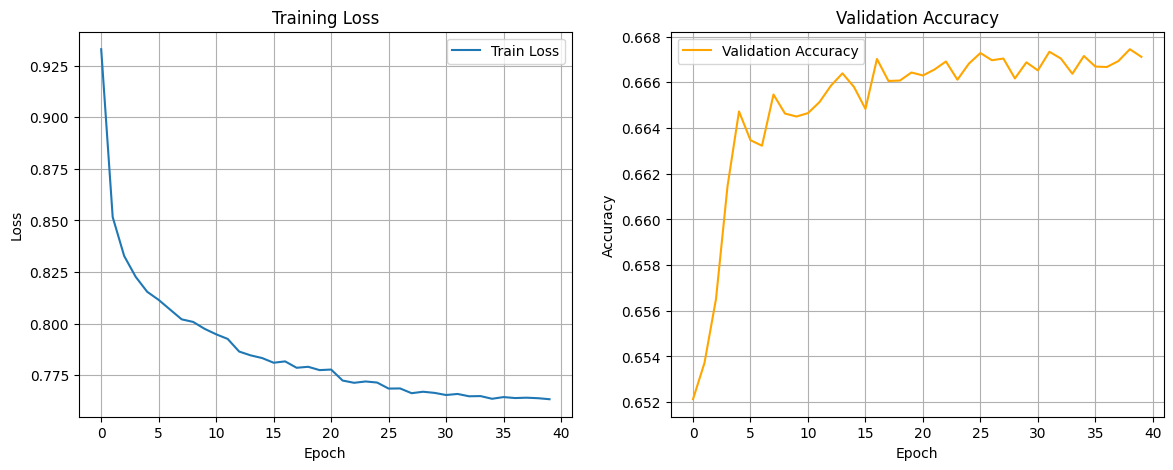

In [44]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Plot training loss
ax[0].plot(train_history, label="Train Loss")
ax[0].set_title("Training Loss")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].grid(True)
ax[0].legend()

# Plot validation accuracy
ax[1].plot(val_history, label="Validation Accuracy", color="orange")
ax[1].set_title("Validation Accuracy")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].grid(True)
ax[1].legend()

plt.show()


In [45]:
test_acc = evaluate(model, test_loader, device)
print(f"Test Accuracy: {test_acc:.4f}")

Test Accuracy: 0.6686


In [46]:
data.trump.value_counts(normalize=True)

trump
PUSH        0.382279
UNE_UFE     0.124097
SPADES      0.111485
CLUBS       0.110487
OBE_ABE     0.099574
HEARTS      0.086395
DIAMONDS    0.085684
Name: proportion, dtype: float64